# Lab 2

grupo
1. Diego Cordova 20212
2. Paola Contreras 20213
3. Paola de León 20361

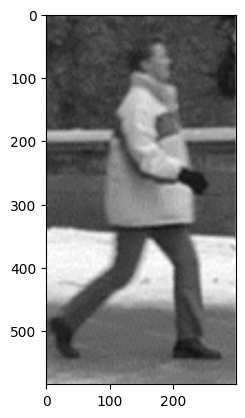

In [10]:
import matplotlib.pyplot as plt
import skimage as ski
import cv2 as cv
import numpy as np

def read_img(filepath):
    data = open(filepath, 'rb')
    img = plt.imread(data)
    return img

img = read_img('./person.png')
plt.imshow(img)

### 1. Implementar una funcion en Python que acepte una imagen a colores, y haga las siguientes transformaciones:
- conversion de RGB a escala de grises
- reescalado (resize) a un tamano (128k, 64k), (ratio 2:1).

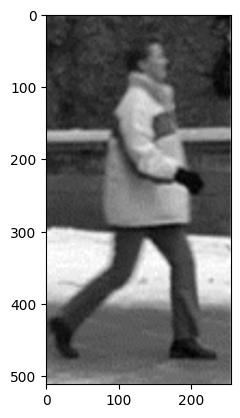

In [17]:
def parte1(img, k):
    if k < 1 or k is None:
        raise Exception('K must be >= 1')

    # grayscale
    # gray_img = ski.color.rgb2gray(img)
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # resize
    resized_img = ski.transform.resize(gray_img, (128 * k, 64 * k))
    return resized_img
  
resized = parte1(img, 4)
plt.imshow(resized, cmap='gray')

### 2. Implementar una funci´on en Python que calcule la magnitud del y angulo del gradiente de una imagen en escala de grises. 
Internamente su algoritmo debe calcular las correlaciones Gx y Gy de la imagen con los filtros de Prewitt

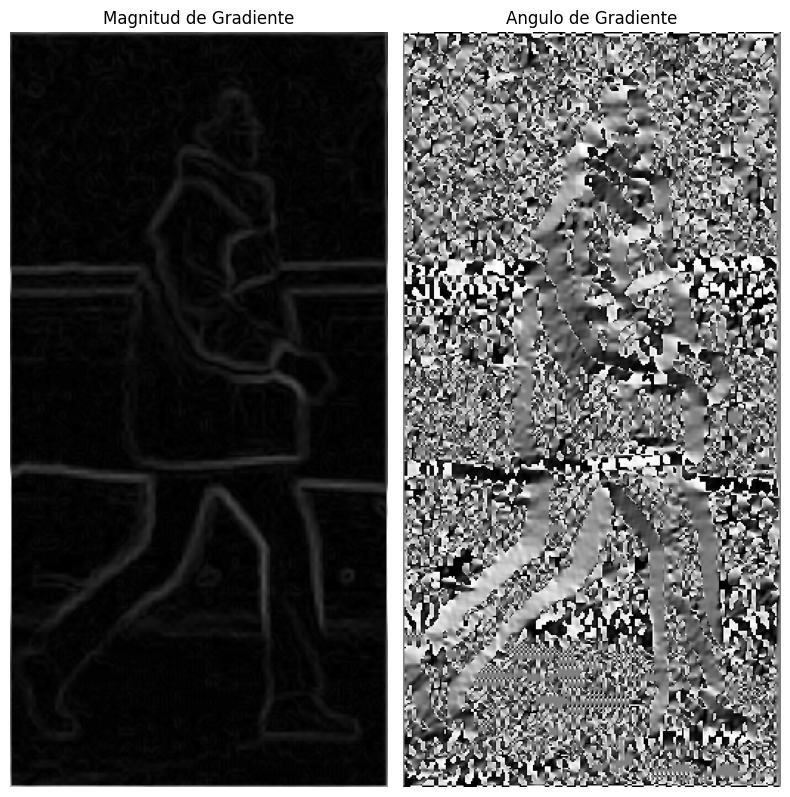

In [23]:
prewittX = np.array([
  [-1, -1, -1 ],
  [ 0,  0,  0 ],
  [ 1,  1,  1 ],
])

prewittY = np.array([
  [-1,  0, 1 ],
  [-1,  0, 1 ],
  [-1,  0, 1 ],
])

def apply_filter(I, filter):
    rows, cols = I.shape
    f_i, f_j = filter.shape

    result = np.zeros_like(I)
    padded_image = np.pad(I, ((1, 1), (1, 1)), mode='constant')

    for i in range(rows):
        for j in range(cols):
            region = padded_image[i:i+f_i, j:j+f_j]
            result[i, j] = np.sum(region * filter)

    return result

def gradient_magnitude_and_angle(image):
    Gx = apply_filter(image, prewittX)
    Gy = apply_filter(image, prewittY)

    # Magnitud
    magnitude = np.sqrt(np.square(Gx) + np.square(Gy))

    # Angulo
    angle = np.arctan2(-Gy, Gx) * 180 / np.pi
    angle %= 180 

    return magnitude, angle

magnitude, angle = gradient_magnitude_and_angle(resized)

fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(magnitude, cmap='gray')
ax[0].set_title('Magnitud de Gradiente')
ax[0].axis('off')

ax[1].imshow(angle, cmap='gray')
ax[1].set_title('Angulo de Gradiente')
ax[1].axis('off')

fig.tight_layout()
plt.show()

### 3. Implementar una funcion en Python que construya el stack de bloques de tamaño block size × block size
usando un stride de block size//2. En este caso, block size debe ser un par´ametro indicado por el usuario (se sugiere que sea un
m´ultiplo de 4, e.g. 4 × 4, 8 × 8, 16 × 16).

La entrada de la funci´on debe ser la imagen μ y θ obtenidas del gradiente, y su funci´on debe devolver dos stack o numpy
arrays de tama˜no M N ×block size × block size, uno para la magnitud y otros para el ´angulo del gradiente. Aqu´ı

In [27]:
def build_stack(magnitude, angle, block_size):
    rows, cols = magnitude.shape
    stride = block_size // 2
    num_blocks_rows = (rows - block_size) // stride + 1
    num_blocks_cols = (cols - block_size) // stride + 1

    # Inicializar los stacks de bloques
    magnitude_stack = np.zeros((num_blocks_rows * num_blocks_cols, block_size, block_size))
    angle_stack = np.zeros((num_blocks_rows * num_blocks_cols, block_size, block_size))

    # Construir los stacks de bloques
    block_index = 0
    for i in range(0, rows - block_size + 1, stride):
        for j in range(0, cols - block_size + 1, stride):
            magnitude_block = magnitude[i:i+block_size, j:j+block_size]
            angle_block = angle[i:i+block_size, j:j+block_size]
            magnitude_stack[block_index] = magnitude_block
            angle_stack[block_index] = angle_block
            block_index += 1

    return magnitude_stack, angle_stack

magnitude_stack, angle_stack = build_stack(magnitude, angle, 8)

print(magnitude_stack.shape)
print(angle_stack.shape)


(8001, 8, 8)
(8001, 8, 8)


### 4. Implementar una funcion en Python que construya el histograma de gradientes, a partir de los stacks de bloques μ y θ.
La construcci´on del histograma debe recibir un n´umero de bines n indicado por el usuario (se sugiere usar n = 9). Internamente
la funci´on deber´a calcular los centros de cada bin, y hacer un barrido de cada uno de los bloques en los stacks. Para cada
bloque, debe calcularse un vector (numpy array de tama˜no n) donde se guardar´a la informaci´on de su respectivo histograma.

La salida de la funci´on debe ser un numpy array H de tama˜no M N × n con la informaci´on de los cada histograma. Los
histogramas deber´an normalizarse utilizando la norma euclideana:

In [28]:
def build_gradient_histogram(magnitude_stack, angle_stack, num_bins):
    num_blocks, block_size, _ = magnitude_stack.shape
    histograms = np.zeros((num_blocks, num_bins))

    # Calcular los centros de los bins
    bin_centers = np.linspace(0, 180, num_bins, endpoint=False)

    # Calcular el ancho de cada bin
    bin_width = 180 / num_bins

    # Iterar sobre los stacks de bloques
    for i in range(num_blocks):
        magnitude_block = magnitude_stack[i]
        angle_block = angle_stack[i]

        # Inicializar el histograma para el bloque actual
        histogram = np.zeros(num_bins)

        # Iterar sobre los píxeles del bloque
        for row in range(block_size):
            for col in range(block_size):
                # Calcular el índice del bin
                bin_index = int(angle_block[row, col] / bin_width)
                
                # Ajustar el ángulo si es igual a 180
                if bin_index == num_bins:
                    bin_index = num_bins - 1

                # Agregar la contribución de la magnitud al bin correspondiente
                histogram[bin_index] += magnitude_block[row, col]

        # Normalizar el histograma utilizando la norma euclidiana
        histogram_norm = np.linalg.norm(histogram)
        if histogram_norm != 0:
            histogram /= histogram_norm

        # Almacenar el histograma normalizado en la matriz de histogramas
        histograms[i] = histogram

    return histograms

gradient_histograms = build_gradient_histogram(magnitude_stack, angle_stack, 9)


### 5. Escribir una funci´on en python que a cada bloque en el stack, convierta el histograma de ese bloque a un representaci´on visual.

Esta representaci´on visual ser´a una matriz de tama˜no block size × block size. Esta imagen se trabaja como una
imagen con fondo negro. Por cada ´ındice en el histograma de dicho bloque, i = 1, 2, . . . , n, se dibujar´a una l´ınea con ´angulo
en el centroide Ci del bin i, y de magnitud o intensidad igual al valor del histograma en el bin i.

Construir una imagen de direcciones que dibuje los histogramas visuales de cada bloque

In [38]:
import cv2
import numpy as np

def visualize_histograms(angle_stack, magnitude_stack, histograms, block_size):
    num_blocks, _, _ = angle_stack.shape
    angle_image = np.zeros((num_blocks * block_size, num_blocks * block_size), dtype=np.uint8)

    # Calcular el centro de cada bin
    bin_centers = np.linspace(0, 180, len(histograms[0]), endpoint=False) + 90 / len(histograms[0])

    # Iterar sobre los bloques
    for i in range(num_blocks):
        angle_block = angle_stack[i]
        magnitude_block = magnitude_stack[i]
        histogram = histograms[i]

        # Iterar sobre los píxeles del bloque
        for row in range(block_size):
            for col in range(block_size):
                # Obtener el ángulo y la magnitud del píxel actual
                angle = angle_block[row, col]
                magnitude = magnitude_block[row, col]

                # Calcular el índice del bin más cercano al ángulo actual
                bin_index = int(np.round(angle / 180 * len(histogram)))
                if bin_index >= len(histogram):
                    bin_index = 0

                # Calcular el punto final de la línea
                x_end = int(col + magnitude * np.cos(np.deg2rad(bin_centers[bin_index])))
                y_end = int(row + magnitude * np.sin(np.deg2rad(bin_centers[bin_index])))

                # Dibujar la línea en la imagen de ángulos
                cv2.line(angle_image, (col + i * block_size, row), (x_end + i * block_size, y_end), int(255 * histogram[bin_index]), thickness=1)

    return angle_image

# Ejemplo de uso
block_size = 8  # Tamaño del bloque
# Suponiendo que tienes los stacks de bloques de ángulo y magnitud del gradiente (angle_stack y magnitude_stack)
# y los histogramas de gradientes (gradient_histograms)
# Ejemplo de llamada a la función
angle_image = visualize_histograms(angle_stack, magnitude_stack, gradient_histograms, block_size)

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_histograms(histograms):
    num_blocks, num_bins = histograms.shape
    block_size = int(np.sqrt(num_bins))  # Suponiendo que los bloques son cuadrados

    # Crear una figura y ejes para visualizar los histogramas
    fig, axes = plt.subplots(num_blocks, num_blocks, figsize=(12, 12))

    # Iterar sobre los histogramas y generar visualizaciones para cada uno
    for i in range(num_blocks):
        for j in range(num_blocks):
            index = i * num_blocks + j
            histogram = histograms[index]
            # Generar los centros de los bins
            bin_centers = np.linspace(0, 180, num_bins, endpoint=False) + 90 / num_bins

            # Graficar el histograma
            axes[i, j].bar(bin_centers, histogram, width=180 / num_bins, color='b', align='center')

            # Configurar los ejes
            axes[i, j].set_xlim([0, 180])
            axes[i, j].set_ylim([0, 1])  # Normalizamos los histogramas al rango [0, 1]
            axes[i, j].set_title(f'Bloque {index}')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
num_blocks = 4
num_bins = 9
histograms = np.random.rand(num_blocks**2, num_bins)  # Histogramas aleatorios para demostración

# Visualizar los histogramas
visualize_histograms(angle_image)


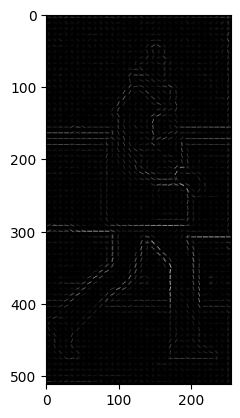

In [36]:
from skimage.feature import hog
fd, hogI = hog(resized, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

plt.imshow(hogI, cmap='gray')
plt.show()


### 6